In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Step 1: Load the Data

In [2]:
df = pd.read_csv('data/videos_featured.csv', sep=';')

### Step 2: Basic Checks

In [3]:
df.head() # View top rows

,video_id,title,published_at,views,likes,comments,duration_seconds,tags_array,published_us_est,published_year,published_month,published_quarter,published_weekday,published_hour,like_ratio,comment_ratio,published_time_of_day
0,DlEkWd-8VXA,250k Subscriber Live Stream!!,2022-07-26 13:19:48,4168,156,11,4539,"{""Alex The Analyst"",""Live Stream"",""250k subscr...",2022-07-26 09:19:48,2022,7,Q3,Tuesday,9,0.0374,0.0026,Morning
1,xb5-UX-jYw0,How to Lie with Data | Averages,2025-04-08 12:01:32,4150,216,14,407,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-04-08 08:01:32,2025,4,Q2,Tuesday,8,0.0520,0.0034,Morning
2,V3ouFOBQP0k,How to Lie with Data | Percentages and Baselin...,2025-04-01 12:00:46,4361,216,9,318,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-04-01 08:00:46,2025,4,Q2,Tuesday,8,0.0495,0.0021,Morning
3,oi9W142ELN0,1 Million YouTube Play Button Unboxing!,2025-03-25 12:01:10,3073,236,79,460,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-03-25 08:01:10,2025,3,Q1,Tuesday,8,0.0768,0.0257,Morning
4,5n52mlp9Ym0,Maven Analytics + Analyst Builder Lifetime Acc...,2025-03-24 12:00:07,8613,254,41,315,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-03-24 08:00:07,2025,3,Q1,Monday,8,0.0295,0.0048,Morning


In [4]:
df.shape # Check the number of rows and columns

(366, 17)

In [5]:
df.columns # Column names

Index(['video_id', 'title', 'published_at', 'views', 'likes', 'comments',
       'duration_seconds', 'tags_array', 'published_us_est', 'published_year',
       'published_month', 'published_quarter', 'published_weekday',
       'published_hour', 'like_ratio', 'comment_ratio',
       'published_time_of_day'],
      dtype='object')

In [6]:
df.dtypes # Check data type of each column

video_id                  object
title                     object
published_at              object
views                      int64
likes                      int64
comments                   int64
duration_seconds           int64
tags_array                object
published_us_est          object
published_year             int64
published_month            int64
published_quarter         object
published_weekday         object
published_hour             int64
like_ratio               float64
comment_ratio            float64
published_time_of_day     object
dtype: object

In [7]:
df.info() # Check nulls + types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   video_id               366 non-null    object 
 1   title                  366 non-null    object 
 2   published_at           366 non-null    object 
 3   views                  366 non-null    int64  
 4   likes                  366 non-null    int64  
 5   comments               366 non-null    int64  
 6   duration_seconds       366 non-null    int64  
 7   tags_array             366 non-null    object 
 8   published_us_est       366 non-null    object 
 9   published_year         366 non-null    int64  
 10  published_month        366 non-null    int64  
 11  published_quarter      366 non-null    object 
 12  published_weekday      366 non-null    object 
 13  published_hour         366 non-null    int64  
 14  like_ratio             366 non-null    float64
 15  commen

### Step 3: Metrics Normalization

In [8]:
# Convert all date time to UTC time zone
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)
today = pd.Timestamp.now(tz='UTC')

# Normalize metrics
df['days_since_publish'] = (today - df['published_at']).dt.days.clip(lower=1) # type: ignore # ensure the minimal day is 1
df['views_per_day'] = df['views']/df['days_since_publish']
df['likes_per_day'] = df['likes']/df['days_since_publish']


# Label duration buckets
df['duration_bucket'] = pd.cut(df['duration_seconds'], 
    bins=[0, 600, 1800, 3600, 100000],
    labels=['Short', 'Medium', 'Long', 'Very Long']
)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   video_id               366 non-null    object             
 1   title                  366 non-null    object             
 2   published_at           366 non-null    datetime64[ns, UTC]
 3   views                  366 non-null    int64              
 4   likes                  366 non-null    int64              
 5   comments               366 non-null    int64              
 6   duration_seconds       366 non-null    int64              
 7   tags_array             366 non-null    object             
 8   published_us_est       366 non-null    object             
 9   published_year         366 non-null    int64              
 10  published_month        366 non-null    int64              
 11  published_quarter      366 non-null    object             

In [10]:
df.head()

,video_id,title,published_at,views,likes,comments,duration_seconds,tags_array,published_us_est,published_year,...,published_quarter,published_weekday,published_hour,like_ratio,comment_ratio,published_time_of_day,days_since_publish,views_per_day,likes_per_day,duration_bucket
0,DlEkWd-8VXA,250k Subscriber Live Stream!!,2022-07-26 13:19:48+00:00,4168,156,11,4539,"{""Alex The Analyst"",""Live Stream"",""250k subscr...",2022-07-26 09:19:48,2022,...,Q3,Tuesday,9,0.0374,0.0026,Morning,1085,3.841475,0.143779,Very Long
1,xb5-UX-jYw0,How to Lie with Data | Averages,2025-04-08 12:01:32+00:00,4150,216,14,407,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-04-08 08:01:32,2025,...,Q2,Tuesday,8,0.0520,0.0034,Morning,98,42.346939,2.204082,Short
2,V3ouFOBQP0k,How to Lie with Data | Percentages and Baselin...,2025-04-01 12:00:46+00:00,4361,216,9,318,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-04-01 08:00:46,2025,...,Q2,Tuesday,8,0.0495,0.0021,Morning,105,41.533333,2.057143,Short
3,oi9W142ELN0,1 Million YouTube Play Button Unboxing!,2025-03-25 12:01:10+00:00,3073,236,79,460,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-03-25 08:01:10,2025,...,Q1,Tuesday,8,0.0768,0.0257,Morning,112,27.437500,2.107143,Short
4,5n52mlp9Ym0,Maven Analytics + Analyst Builder Lifetime Acc...,2025-03-24 12:00:07+00:00,8613,254,41,315,"{""Data Analyst"",""Data Analyst job"",""Data Analy...",2025-03-24 08:00:07,2025,...,Q1,Monday,8,0.0295,0.0048,Morning,113,76.221239,2.247788,Short


### Step 4: Descriptive Statistics
#### Statistics for numerical data

In [11]:
df.describe() # Summary for numeric columns

,views,likes,comments,duration_seconds,published_year,published_month,published_hour,like_ratio,comment_ratio,days_since_publish,views_per_day,likes_per_day
count,3.660000e+02,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,1.390425e+05,3328.486339,180.199454,1700.691257,2022.297814,6.327869,8.341530,0.033302,0.003144,1005.734973,152.704968,3.938172
std,2.597877e+05,5760.090393,385.038146,4786.842221,1.570741,3.537144,2.555847,0.016346,0.005271,567.572358,296.443834,8.215038
min,2.590000e+02,34.000000,3.000000,9.000000,2020.000000,1.000000,0.000000,0.012000,0.000200,28.000000,0.955944,0.056148
25%,1.292150e+04,435.000000,30.000000,386.250000,2021.000000,3.000000,7.000000,0.021825,0.000800,553.250000,19.384868,0.683498
50%,3.568100e+04,1332.500000,77.000000,721.000000,2022.000000,6.000000,8.000000,0.029550,0.001600,934.500000,56.650769,1.841887
75%,1.397555e+05,3597.750000,161.750000,1581.500000,2024.000000,9.750000,9.000000,0.039300,0.003175,1553.500000,168.566806,4.231954
max,2.174630e+06,48329.000000,4370.000000,84768.000000,2025.000000,12.000000,23.000000,0.131300,0.063800,2006.000000,2571.797235,109.903226


#### Interpretation:
- Huge difference between **mean** and **median**-> strong right skew in `views` and `likes`
- `comments` also skewed
- Outliers are pulling the average up
- Maximum of duration(84,768 s, about 23.5 hrs!) suggests at least one extremely long video
- Most videos published between morning hours

#### Suggestions:
- Use **log scale** when visualizing `views` and `likes`
- Bin durations into categories: Short, Medium, Long, Very Long
- Consider remove extreme values
- User `views_per_day` and `likes_per_day` for grouped trend analyses


#### Statistics for non-numerical data

In [12]:
weekday_counts = df['published_weekday'].value_counts() # Published total videos of each weekday
weekday_summary = pd.DataFrame(
    {'Video Count': weekday_counts,
     '% of Total': (weekday_counts/weekday_counts.sum()*100).round(1)        
    }
)

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_summary = weekday_summary.reindex(weekday_order)

print(weekday_summary)

                   Video Count  % of Total
published_weekday                         
Monday                      19         5.2
Tuesday                    238        65.0
Wednesday                   28         7.7
Thursday                    55        15.0
Friday                      17         4.6
Saturday                     6         1.6
Sunday                       3         0.8


In [13]:
hour_counts = df['published_hour'].value_counts() # Published total videos of each hour
hour_summary = pd.DataFrame(
    {'Video_count':hour_counts,
     '% of Total': (hour_counts/hour_counts.sum()*100).round(1)        
    }
)

hour_order = [0,6,7,8,9,10,11,12,13,14,19,21,22,23]
hour_summary = hour_summary.reindex(hour_order)

print(hour_summary)

                Video_count  % of Total
published_hour                         
0                         2         0.5
6                        50        13.7
7                        88        24.0
8                       128        35.0
9                        23         6.3
10                       24         6.6
11                       19         5.2
12                       19         5.2
13                        4         1.1
14                        2         0.5
19                        1         0.3
21                        3         0.8
22                        2         0.5
23                        1         0.3


In [14]:
daytime_counts = df['published_time_of_day'].value_counts() # Published total videos of each time of day
daytime_summary = pd.DataFrame(
    {'Video_counts': daytime_counts,
     '% of Total': (daytime_counts/daytime_counts.sum()*100).round(1)
        
    }
)

daytime_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening']
daytime_summary = daytime_summary.reindex(daytime_order)

print(daytime_summary)


                       Video_counts  % of Total
published_time_of_day                          
Early Morning                     2         0.5
Morning                         332        90.7
Afternoon                        25         6.8
Evening                           7         1.9


### Step 4: Visualize Distributions and Patterns

d:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


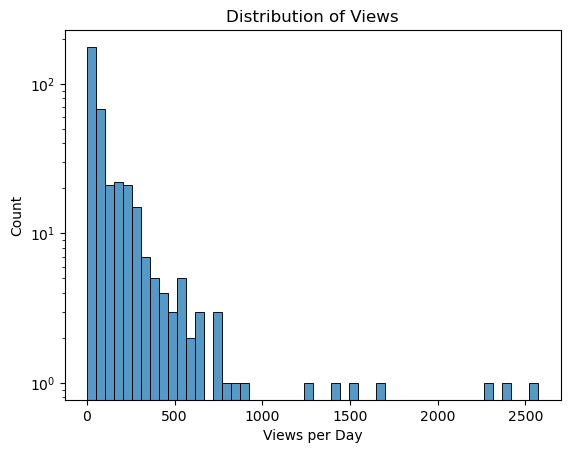

In [15]:
# Views distribution
sns.histplot(df['views_per_day'], bins=50) # type: ignore
plt.title("Distribution of Views")
plt.xlabel('Views per Day')
plt.yscale('log')

#### Interpretation:
- **Majority of Low Views**: A substantial portion of the data points fall into the lowest view categories. For example, over 175 items have very few views per day, and roughly 70 have slightly more (perhaps up to 100-150 views/day).

- **Decreasing Frequency**: As the number of views per day increases, the frequency of items with that many views rapidly decreases.

- **Rare High Performers**: Only a very small number of items achieve high view counts. For instance, there are only a handful of items with views between 500 and 1000 per day, and even fewer above 1000.

Text(0.5, 1.0, 'Total Videos along Published Weekday')

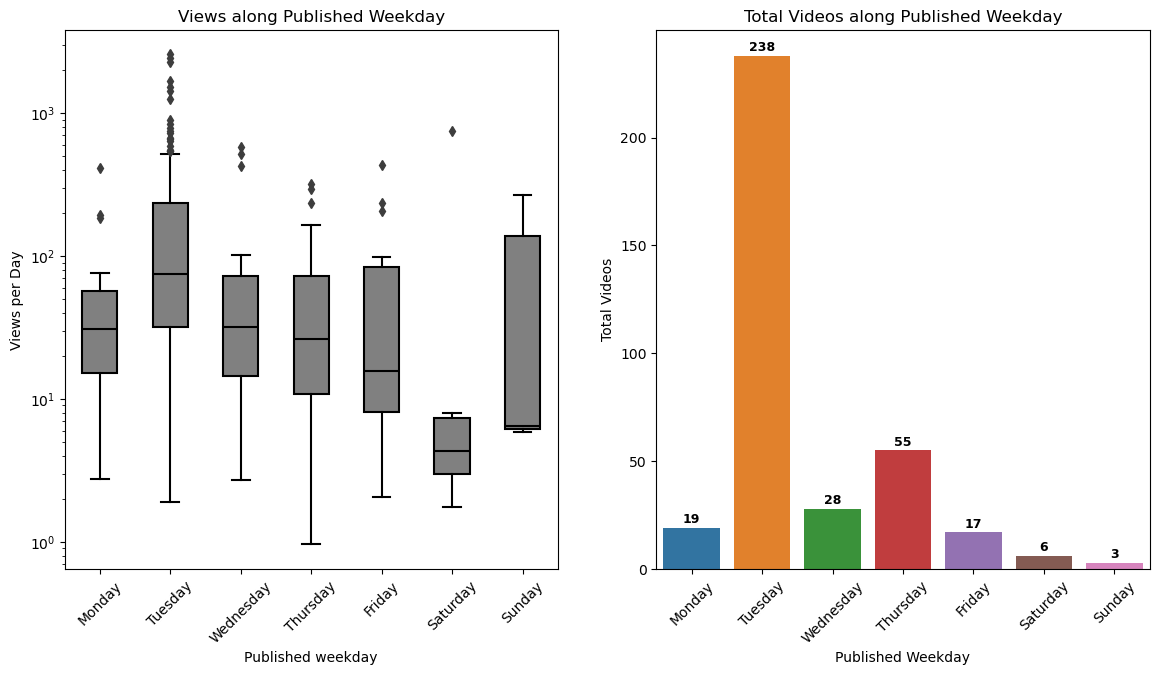

In [16]:
fig, axes = plt.subplots(1,2,figsize = (14,7))

# Boxplot of views by weekday
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='published_weekday', y='views_per_day', data=df, order = weekday, showfliers=True, width=0.5,ax=axes[0],
            boxprops=dict(facecolor='gray', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
axes[0].set_ylabel('Views per Day')
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Published weekday')
axes[0].set_title("Views along Published Weekday")


# Barplot of the views distribution along weekday
sns.countplot(x='published_weekday', data=df, order=weekday, ax=axes[1])
for p in axes[1].patches:
    count = int(p.get_height())
    axes[1].text(p.get_x() + p.get_width() / 2,
                 p.get_height() + 1,
                 str(count),
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[1].set_ylabel('Total Videos')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Published Weekday')
axes[1].set_title("Total Videos along Published Weekday")

**Insights**: 
- Tuesday videos tend to perform more consistently well. 
- Monday, Wednesday, Thursday and Friday all have a high median.
- Saturday is consistently underperforming.
- Sunday performs better than Saturday, but still has a low median views.

Text(0.5, 1.0, 'Total Videos along Published Day of Time')

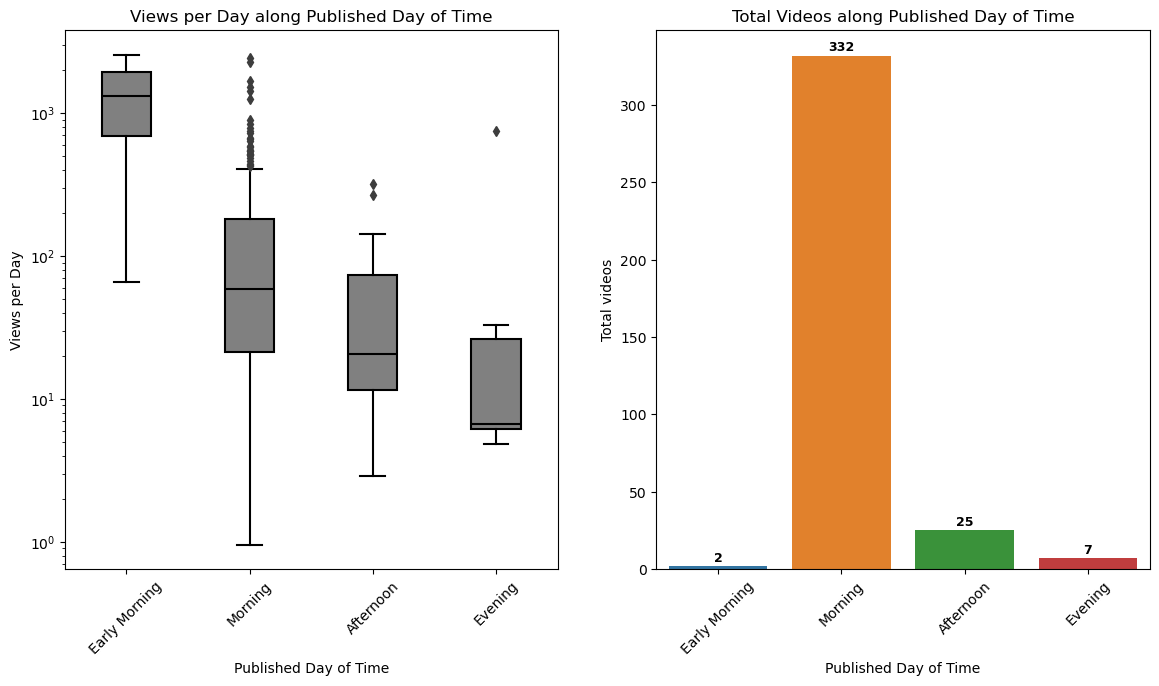

In [17]:
fig, axes = plt.subplots(1,2,figsize = (14,7))

day_of_time=['Early Morning', 'Morning', 'Afternoon', 'Evening']

# Distribution of  views per day by time of day
sns.boxplot(x='published_time_of_day', y='views_per_day', data=df, order=day_of_time, width=0.4, ax=axes[0],
            boxprops=dict(facecolor='gray', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

axes[0].set_ylabel('Views per Day')
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Published Day of Time')
axes[0].set_title("Views per Day along Published Day of Time")



# Barplot of the views distribution along weekday
sns.countplot(x='published_time_of_day', data=df, order=day_of_time, ax=axes[1])

for p in axes[1].patches:
    count = int(p.get_height())
    axes[1].text(p.get_x() + p.get_width() / 2,
                 p.get_height() + 1,
                 str(count),
                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    


axes[1].set_ylabel('Total videos')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Published Day of Time')
axes[1].set_title("Total Videos along Published Day of Time")


Text(0.5, 1.0, 'Likes per Day along Published Day of Time')

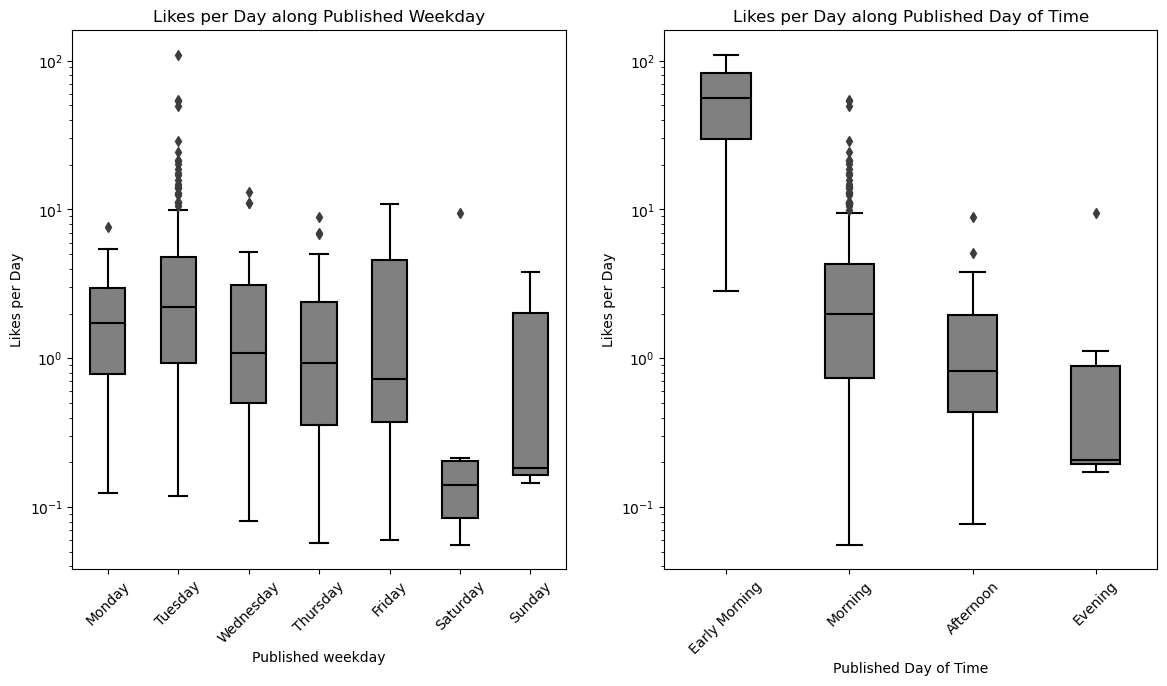

In [23]:
fig, axes = plt.subplots(1,2,figsize = (14,7))

# Boxplot of views by weekday
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='published_weekday', y='likes_per_day', data=df, order = weekday, showfliers=True, width=0.5,ax=axes[0],
            boxprops=dict(facecolor='gray', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
axes[0].set_ylabel('Likes per Day')
axes[0].set_yscale('log')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Published weekday')
axes[0].set_title("Likes per Day along Published Weekday")


day_of_time=['Early Morning', 'Morning', 'Afternoon', 'Evening']

# Distribution of  views per day by time of day
sns.boxplot(x='published_time_of_day', y='likes_per_day', data=df, order=day_of_time, width=0.4, ax=axes[1],
            boxprops=dict(facecolor='gray', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

axes[1].set_ylabel('Likes per Day')
axes[1].set_yscale('log')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Published Day of Time')
axes[1].set_title("Likes per Day along Published Day of Time")

d:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Duration in Seconds')

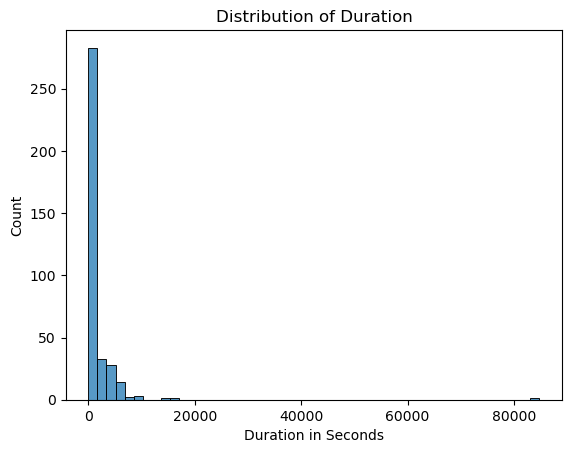

In [19]:
sns.histplot(df['duration_seconds'], bins=50) # type: ignore
plt.title("Distribution of Duration")
plt.xlabel('Duration in Seconds')

d:\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


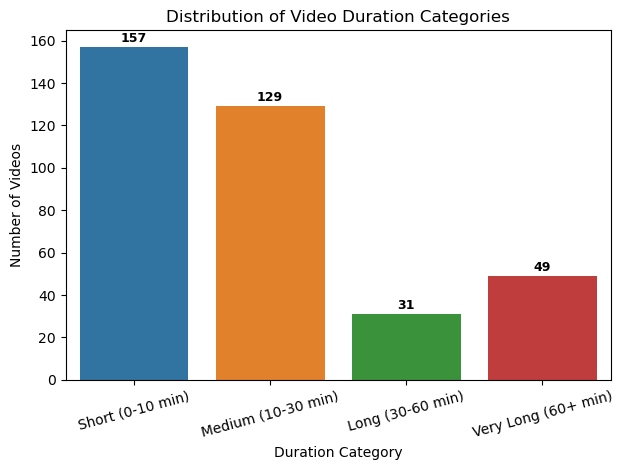

In [42]:
# Define duration buckets
fig, axes=plt.subplots()

df['duration_bucket'] = pd.cut(
    df['duration_seconds'],
    bins=[0, 600, 1800, 3600, 100000],
    labels=['Short (0-10 min)', 'Medium (10-30 min)', 'Long (30-60 min)', 'Very Long (60+ min)'],
    right=False
)

# Plot duration distribution
sns.countplot(x='duration_bucket', data=df, ax=axes)  # Use countplot for category frequencies

for p in axes.patches:
    count = int(p.get_height())
    axes.text(p.get_x() + p.get_width() / 2,
                 p.get_height() + 1,
                 str(count),
                 ha='center', va='bottom', fontsize=9, fontweight='bold')
    

plt.title("Distribution of Video Duration Categories")
plt.xlabel("Duration Category")
plt.ylabel("Number of Videos")
plt.xticks(rotation=15)
plt.tight_layout()

d:\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Short (0-10 min)'),
  Text(1, 0, 'Medium (10-30 min)'),
  Text(2, 0, 'Long (30-60 min)'),
  Text(3, 0, 'Very Long (60+ min)')])

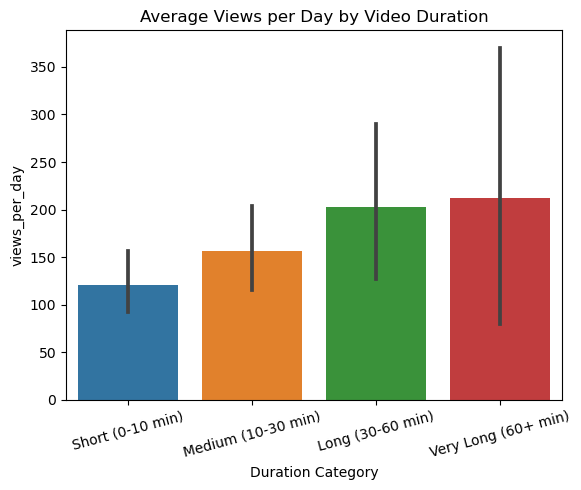

In [36]:
sns.barplot(x='duration_bucket', y='views_per_day', data=df, estimator='mean')
plt.title("Average Views per Day by Video Duration")
plt.xlabel("Duration Category")
plt.xticks(rotation=15)


d:\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 1.0, 'Video Duration vs Views per Day')

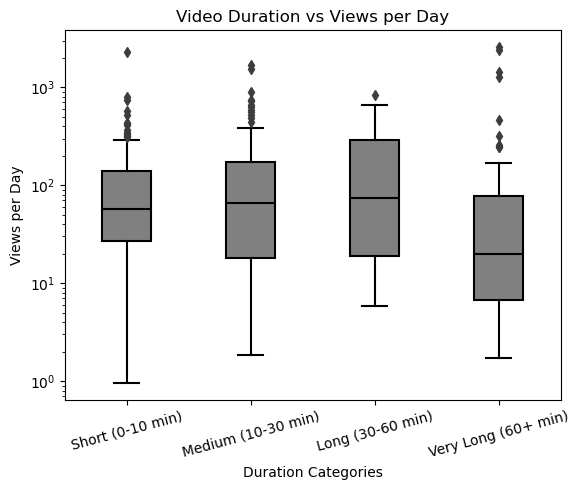

In [32]:
# Like ratio vs duration
sns.boxplot(x='duration_bucket', y='views_per_day', data=df, width=0.4, 
            boxprops=dict(facecolor='gray', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
plt.yscale('log')
plt.xlabel('Duration Categories')
plt.ylabel('Views per Day')
plt.xticks(rotation=15)
plt.title("Video Duration vs Views per Day")

d:\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Short (0-10 min)'),
  Text(1, 0, 'Medium (10-30 min)'),
  Text(2, 0, 'Long (30-60 min)'),
  Text(3, 0, 'Very Long (60+ min)')])

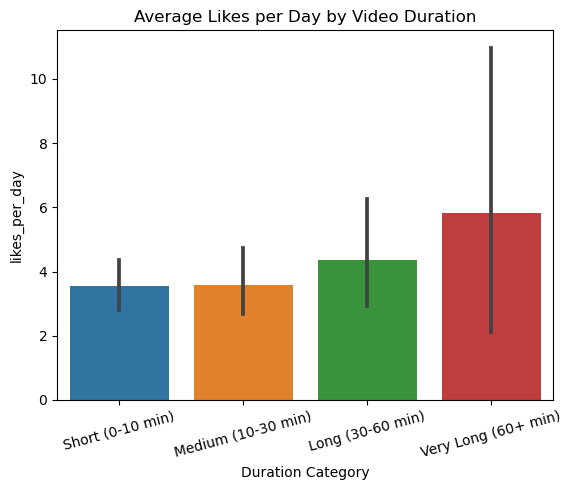

In [37]:
sns.barplot(x='duration_bucket', y='likes_per_day', data=df, estimator='mean')
plt.title("Average Likes per Day by Video Duration")
plt.xlabel("Duration Category")
plt.xticks(rotation=15)

d:\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 1.0, 'Video Duration vs Likes per Day')

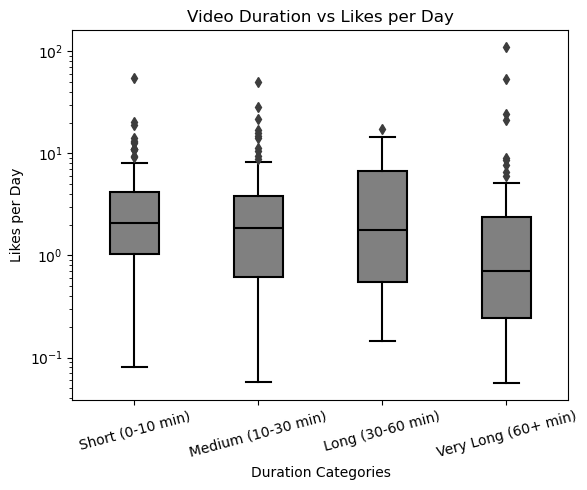

In [38]:
sns.boxplot(x='duration_bucket', y='likes_per_day', data=df, width=0.4, 
            boxprops=dict(facecolor='gray', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
plt.yscale('log')
plt.xlabel('Duration Categories')
plt.ylabel('Likes per Day')
plt.xticks(rotation=15)
plt.title("Video Duration vs Likes per Day")